### Import Lib

In [1]:
import os, json, copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models import vgg16, VGG16_Weights

from utils import get_features, init_weight, Total_Loss, makeBox
from dataset import custom_dataset

C:\Users\user\anaconda3\envs\anomal\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### GPU 설정

In [2]:
USE_CUDA = torch.cuda.is_available()
device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print(device)

cuda:0


### Dataset 생성 및 시각화

In [3]:
dataset = custom_dataset(device=device)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

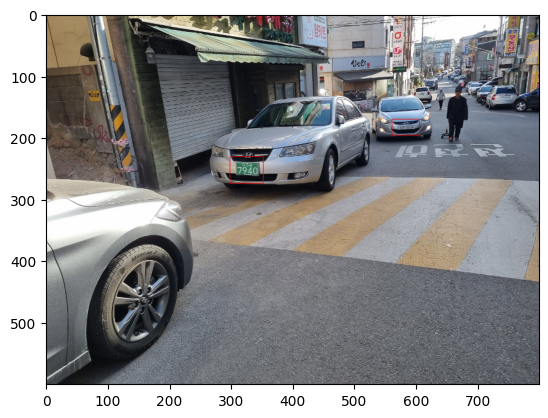

In [4]:
img, bbox = dataset.__getitem__(3)
test = makeBox(img.permute(1,2,0).numpy(), bbox)
plt.imshow(test)
plt.show()

### model 생성

In [5]:
backbone = torchvision.models.vgg16(weights=VGG16_Weights.DEFAULT).features[:-1] # maxpooling 제거
backbone_out = 512
backbone.out_channels = backbone_out # 마지막 채널 512

In [6]:
anchor_generator = torchvision.models.detection.rpn.AnchorGenerator(sizes=((128, 256, 512),),aspect_ratios=((0.5, 1.0, 2.0),)) # k=9로 anchor box 생성
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
resolution = 7
box_head = torchvision.models.detection.faster_rcnn.TwoMLPHead(in_channels= backbone_out*(resolution**2),representation_size=4096) 
box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(4096,2) #21개 class

In [7]:
model = torchvision.models.detection.FasterRCNN(backbone, num_classes=None,
                   min_size = 600, max_size = 1000,
                   rpn_anchor_generator=anchor_generator,
                   rpn_pre_nms_top_n_train = 6000, rpn_pre_nms_top_n_test = 6000,# rpn 후보 생성 중 상위 n개를 뽑아 train, test
                   rpn_post_nms_top_n_train=2000, rpn_post_nms_top_n_test=300,# rpn 후보 선택 중 상위 n개를 뽑아 train, test
                   rpn_nms_thresh=0.7,rpn_fg_iou_thresh=0.7,  rpn_bg_iou_thresh=0.3, # nms thresh / positive, negative 조건
                   rpn_batch_size_per_image=4, rpn_positive_fraction=0.5, # 후보의 batch size 크기 / postive, negative 비율 1:1
                   box_roi_pool=roi_pooler, box_head = box_head, box_predictor = box_predictor,
                   box_score_thresh=0.05, box_nms_thresh=0.9,box_detections_per_img=300,
                   box_fg_iou_thresh=0.5, box_bg_iou_thresh=0.5,
                   box_batch_size_per_image=128, box_positive_fraction=0.25
                 )

In [8]:
init_weight(model)

### Load model

In [9]:
PATH = './weight/test_class_1.pth'
model = torch.load(PATH)
model.eval();

#### GeneralizedRCNNTransform : (Input size) -> (1000, 600) (예시)
#### Backbone (img_extractor) : (1000, 600) -> (60, 40)
#### rpn
##### - Anchor_generator : 60x40xk개의 anchor 생성 후 nms 전처리전 n개 선택 -> nms를 통해 겹치는 영역 제거후 iou를 이용해 상위 n개를 선택(positve:negative = 1:1)
##### - rpn_head : Conv(512)+Relu -> obj 여부(k*1) / bbox 예측(k*4)
#### roi_heads
##### - box_roi_pool : SPP의 원리를 max, averaging pooling이 아닌 다른 pooling을 이용하여 적용
##### - box_head + cls score : classification
##### - box_head + bbox_pred : 정확한 bbox

### Train

In [10]:
epoch = 70

optimizer = torch.optim.SGD(params = model.parameters(),lr = 0.001, momentum = 0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,epoch,eta_min=0.00001)

model.to('cuda');

In [10]:
model.train();

In [11]:
loss_sum = 0.

for i_epoch in range(epoch):
    
    for image,targets in tqdm(dataloader):
            
        optimizer.zero_grad()
        
        targets[0]['boxes'].squeeze_(0)
        targets[0]['labels'].squeeze_(0)
        
        # train mode에서는 정답을 같이 넣어 줘야함.
        loss = model(image.to(device),targets)
        
        total_loss = Total_Loss(loss)
        loss_sum += total_loss
        
        total_loss.backward()
        optimizer.step()
        
        loss_sum = 0
        
    scheduler.step()

100%|████████████████████████████████████████████████████████████████████████████████| 203/203 [00:52<00:00,  3.83it/s]


In [13]:
torch.save(model,'./weight/test.pth')

### Test

In [11]:
model.eval();

In [14]:
test_image, bbox = dataset.__getitem__(1)

predictions = model(test_image.unsqueeze(0).to(device))
boxes = predictions[0]['boxes'].detach().to('cpu')
labels = predictions[0]['labels'].detach().to('cpu')
# torch.cuda.empty_cache()

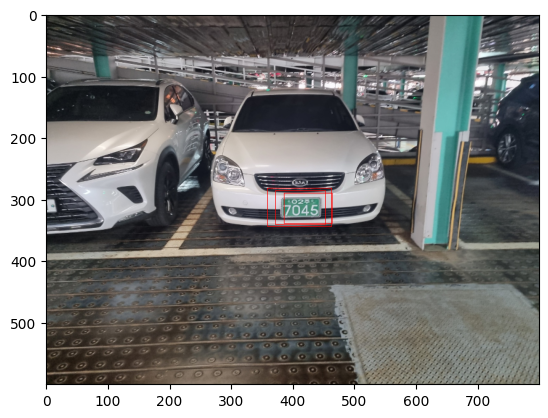

In [15]:
test = makeBox(test_image.permute(1,2,0).numpy(), boxes)
plt.imshow(test)
plt.show()